In [ ]:
#Risk Level → multi-class classifier (Logistic Regression / Random Forest / Neural Network).

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn

In [21]:
# === Load data ===
data = pd.read_csv("merged_numeric_data_ready_for_prediction.csv")  
# === STEP 1: Detect ticker leakage ===
ticker_risks = data.groupby('ticker')['Risk Level'].nunique().reset_index()
ticker_risks.columns = ['ticker', 'unique_risk_levels']

print("\nUnique Risk Levels per Ticker:")
print(ticker_risks['unique_risk_levels'].value_counts())

multi_risk_tickers = ticker_risks.loc[ticker_risks['unique_risk_levels'] > 1, 'ticker']

if len(multi_risk_tickers) == 0:
    print("\n clean to avoid data leakage.")
    filtered_data = data.copy()
    use_ticker = False
else:
    print(f"\nKeeping {len(multi_risk_tickers)} tickers that vary in Risk Level.")
    filtered_data = data[data['ticker'].isin(multi_risk_tickers)]
    use_ticker = True


Unique Risk Levels per Ticker:
unique_risk_levels
1    4800
Name: count, dtype: int64

 clean to avoid data leakage.


In [22]:
# === STEP 2: Encode target ===
y = filtered_data['Risk Level']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [23]:
# === STEP 3: Prepare features ===
if use_ticker:
    X = filtered_data[['ticker', 'year', 'year_scaled']]
    categorical_features = ['ticker']
else:
    X = filtered_data[['year', 'year_scaled']]
    categorical_features = []

numeric_features = ['year', 'year_scaled']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [24]:
# === STEP 4: Split Data ===
if use_ticker:
    splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
    for train_idx, test_idx in splitter.split(X, y_encoded, groups=filtered_data['ticker']):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )


In [25]:

# === STEP 5: Define models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}



===== Logistic Regression =====
Accuracy: 1.0
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       143
         Low       1.00      1.00      1.00       363
      Medium       1.00      1.00      1.00       456

    accuracy                           1.00       962
   macro avg       1.00      1.00      1.00       962
weighted avg       1.00      1.00      1.00       962

Confusion Matrix:
 [[143   0   0]
 [  0 363   0]
 [  0   0 456]]


C:\Users\pnyamoha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


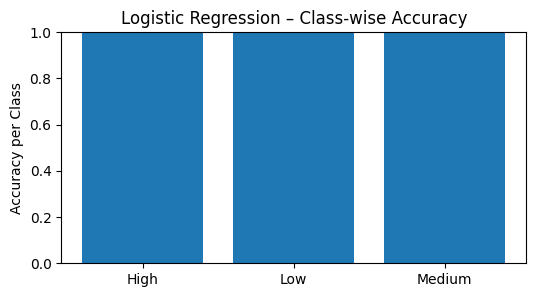


===== Random Forest =====
Accuracy: 1.0
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       143
         Low       1.00      1.00      1.00       363
      Medium       1.00      1.00      1.00       456

    accuracy                           1.00       962
   macro avg       1.00      1.00      1.00       962
weighted avg       1.00      1.00      1.00       962

Confusion Matrix:
 [[143   0   0]
 [  0 363   0]
 [  0   0 456]]


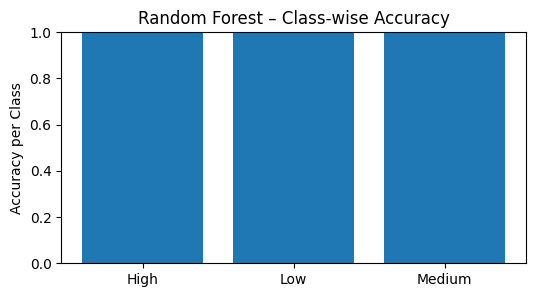

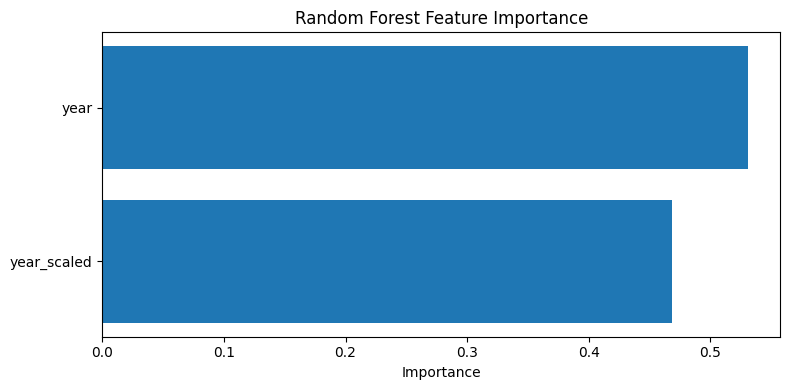


===== Neural Network =====
Accuracy: 1.0
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       143
         Low       1.00      1.00      1.00       363
      Medium       1.00      1.00      1.00       456

    accuracy                           1.00       962
   macro avg       1.00      1.00      1.00       962
weighted avg       1.00      1.00      1.00       962

Confusion Matrix:
 [[143   0   0]
 [  0 363   0]
 [  0   0 456]]


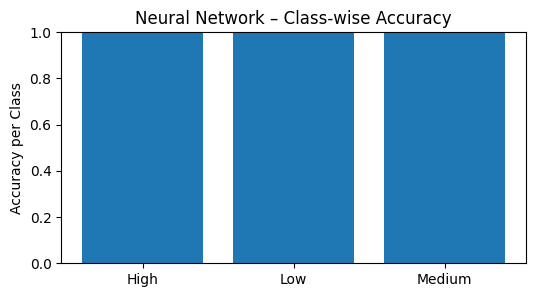

In [26]:

# === STEP 6: Train, Evaluate, and Visualize ===
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(acc, 3))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # === Class-wise accuracy plot ===
    class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(6, 3))
    plt.bar(label_encoder.classes_, class_acc)
    plt.title(f"{name} – Class-wise Accuracy")
    plt.ylabel("Accuracy per Class")
    plt.ylim(0, 1)
    plt.show()

    # === Random Forest Feature Importance ===
    if name == "Random Forest":
        # Get feature names from the pipeline safely
        cat_features = []
        if use_ticker:
            ohe = clf.named_steps['preprocessor'].named_transformers_['cat']
            if hasattr(ohe, 'get_feature_names_out'):
                cat_features = list(ohe.get_feature_names_out(categorical_features))
            else:
                # fallback for older scikit-learn
                cat_features = list(ohe.categories_[0])
        feature_names = cat_features + numeric_features

        importances = clf.named_steps['classifier'].feature_importances_
        sorted_idx = np.argsort(importances)[::-1]

        plt.figure(figsize=(8, 4))
        plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
        plt.title("Random Forest Feature Importance")
        plt.xlabel("Importance")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()